Simple 2D gaussian fitting of a PSF is not working well, at all.  Splitting this
out from where I'm seeing the problem, in Sunburst_measure_line_ratios.ipynb, to its own section, so I can ask for help.  -jrigby, oct 2021

In [180]:
import jrr
import numpy as np
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.stats import gaussian_fwhm_to_sigma
import matplotlib.pyplot as plt

In [181]:
def sigmainpix_2_fwhm_inpix(sigma) :
    return(   np.round((sigma / gaussian_fwhm_to_sigma), 3))

In [182]:
# Benchmark is still iraf imexam. From Iraf imexam running on asdwebdev-sl.gsfc.nasa.gov:
# Iraf imexam fitting:                  PSF FWHM (pixels)
# Sunburst_F160Wv4_largePSF.fits (_v2)   4.8
# Michael's iraf agrees w mine.  So, need to figure out why fitting below is so broken.

The data


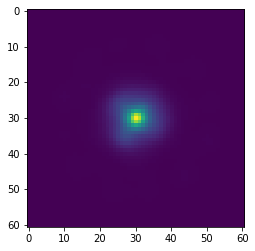

In [183]:
scaleit = 1E6  # maybe fitter is having numerical issues?
# Empirical PSF from Michael Florian, from drizzled data products, F160W PSF, from 10--12 stars
psf_file = 'Example_data/Sunburst_F160Wv4_largePSF.fits.gz'
psf_data, psf_header   = fits.getdata(psf_file,  header=True)
# https://stackoverflow.com/questions/55883497/how-do-you-extract-a-point-spread-function-from-a-fits-image
ysize, xsize = psf_data.shape  # Coax astropy.modeling.fitting into handling 2D
plt.imshow(psf_data)
print("The data")

In [185]:
# What if fit is terrible b/c no weights are used, so it's weighting blank space more than signal?
xsize, ysize

(61, 61)

uncertainty map


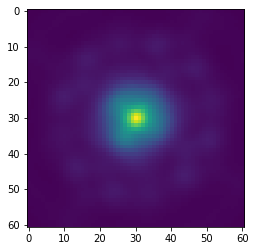

In [186]:
y, x, = np.mgrid[:ysize, :xsize]
f_init = models.Gaussian2D(0.1 * scaleit, 30., 30., 1.5, 1.5, 0.0) + models.Const2D(25)
fit_f = fitting.LevMarLSQFitter()
psf_unc = np.sqrt(psf_data * scaleit + 1E-9)
plt.imshow(psf_unc)
print("uncertainty map")

In [195]:
np.max(psf_data * scaleit), np.max(psf_unc), np.min(psf_unc)

(13769.502, 117.34352, 2.6443367)

The initialization of the fit


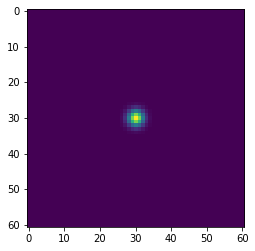

In [187]:

f = fit_f(f_init, x, y, psf_data * scaleit, weights=1/psf_unc, maxiter=200000)
plt.imshow(f_init(x,y))
print("The initialization of the fit")

This fit is terrible! What's wrong?


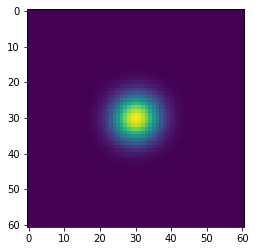

In [188]:
plt.imshow(f(x,y))  
print("This fit is terrible! What's wrong?")

In [189]:
print(f)
size = [f[0].x_stddev.value,  f[0].y_stddev.value]
print("PSF stddev:", np.round(size, 3), "pixels in x, y") 
print("This is", sigmainpix_2_fwhm_inpix(size[0]), sigmainpix_2_fwhm_inpix(size[1]), "pix FWHM") 
print("This is much bigger than what iraf imexam gets: 4.8 pix FWHM.")
print("And this fit looks terrible!")

Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian2D(amplitude=6680.8221601, x_mean=30.0019998, y_mean=29.98817115, x_stddev=4.5102292, y_stddev=4.35562131, theta=-6.68571788)>

    [1]: <Const2D(amplitude=24.37424051)>
Parameters:
       amplitude_0         x_mean_0           y_mean_0         x_stddev_0         y_stddev_0          theta_0          amplitude_1    
    ----------------- ------------------ ----------------- ------------------ ------------------ ------------------ ------------------
    6680.822160103763 30.001999804744713 29.98817114644597 4.5102291974503625 4.3556213096421015 -6.685717875921048 24.374240509258108
PSF stddev: [4.51  4.356] pixels in x, y
This is 10.621 10.257 pix FWHM
This is much bigger than what iraf imexam gets: 4.8 pix FWHM.
And this fit looks terrible!


In [190]:
gaussian_fwhm_to_sigma

0.42466090014400953

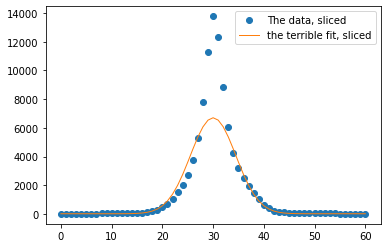

In [191]:
whichrow = 30
plt.plot(psf_data[whichrow,] *scaleit, marker='o', label='The data, sliced', ls='')
plt.plot(f(x,y)[whichrow,], ls='-', label='the terrible fit, sliced')
plt.legend()

In [192]:
print('fit_method = ', fit_f.fit_info)

fit_method =  {'nfev': 73, 'fvec': array([6.56192961, 5.9844786 , 6.02918271, ..., 5.97480238, 5.93893075,
       6.52365489]), 'fjac': array([[-3.28679567e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.01623718e+02, -3.01804127e+02,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.29478260e+00,  8.60194668e+00, -2.02046427e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 8.98059995e-01, -1.36165217e+00, -4.02746981e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.14176668e+00, -8.38103852e-01,  9.67869377e-03, ...,
         3.20708282e-02,  3.19712224e-02,  3.36130754e-02],
       [-8.20510081e-02, -5.85869226e-02, -4.00164427e-04, ...,
         1.59570605e-03,  1.59075009e-03,  1.67244162e-03]]), 'ipvt': array([5, 4, 3, 2, 6, 7, 1], dtype=int32), 'qtf': array([ 0.01228114,  0.00752434,  0.001594  , -0